# DATASCI W261: Machine Learning at Scale 

**Name: Carlos Eduardo Rodriguez Castillo**

**email: cerodriguez@berkeley.edu**

**Week 2**

**Section 2**


### This notebook attempts to solve the questions in the week 2 assignment.

#### HW2.0

What is a race condition in the context of parallel computation? Give an example.

__ANSWER:__

In the context of parallel computation, a race condition is the situation where a program's execution has non-deterministic results. This non-determinism is a function of the program attempting to do operations that, to output the appropriate values, need to execute in a particular order but, due to limitations of the underlying device or the nature of how the software was written, this necessary order cannot be guaranteed.

An example of a race condition in the context of parallel computation is when two threads are each incrementing a counter by one. They each need to independently read in the value for the counter, increment the value, and then write it back to the counter variable. If each of the threads proceeds sequentially (one thread does all incrment operations first and then the second thread proceeds), the expected value (two plus counter) for the counter would be the final value. That said, if the counter variable is read sequentially by the threads and then incremented and written to, the final value for the counter will be an erroneous/unexpected value (one plus counter).

What is MapReduce?

__ANSWER:__

MapReduce is a programming model for executing operations on large datasets through two main operations, in a distributed fashion that permits the programmer to abstract away from most of the intricacies of managing distributed/parallel computation. The MapReduce model has two phases to computation: the __map__ phase where the same operation is applied in parallel to all input records in a dataset, producing intermediate outputs that are then inputs to the second phase, __reduce__, which aggregates these inputs. Both __map__ and __reduce__ each take as inputs a set of inputs and a user defined function respectively.

MapReduce is also the name of the Hadoop-specific implementation of this programming model.

How does it differ from Hadoop?

__ANSWER:__

MapReduce differs from Hadoop in that Hadoop is a framework that fascilitates the MapReduce programming model, but it additionally encompasses a file structure, called HDFS (Hadoop Distributed File System), to support the MapReduce model.

Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.

__ANSWER:__

Hadoop is based on the functional programming paradigm (as opposed to the object-oriented programming paradigm). The functional programming paradigm is one that primarily treats computation as the evaluation of functions given inputs; as such functions, instead of objects, are the fundamental building blocks of programs. Functional programming avoids changing states and prefers to operate on immutable data.

Mathematical functions tend to be great examples of implementations of functional programming; see below for a toy functional programming implementation of computing the average number of tokens in a set of documents:

In [92]:
## mapper function
def mini_map(record):
    counter = 0
    for char in record:
        counter = counter + 1
    return counter
## reducer function
## we assume that there is a single key
## and reducer in this example
def mini_reduce(counters):
    num_records = 0
    final_counter  = 0
    for counter in counters:
        num_records = num_records + 1
        final_counter = final_counter + int(counter)
    average = float(final_counter) / float(num_records)
    return average

## run the MapReduce toy example
strings = ["str1", "string2", "w261", "MAchine learning at SCALE"]
intermediate_results = []
for string in strings:
    intermediate_results.extend([mini_map(string)])
result = mini_reduce(intermediate_results)
print "The average characters per document is: %.2f" % result

The average characters per document is: 10.00


#### HW2.1. Sort in Hadoop MapReduce

Given as input: Records of the form 'integer, “NA”', where integer is any integer, and “NA” is just the empty string.
Output: sorted key value pairs of the form 'integer, “NA”' in decreasing order using a single reducer. What happens if you have multiple reducers? Do you need additional steps? Explain. Feel free to code this up (This is an optional task).

__ANSWER:__

In the case where you have a single reducer, since the MapReduce framework sorts by key during the shuffle (passing data from mappers to reducer) the single output file from the reducer will have all records sorted as expected.

In the case where you have multiple reducers, each of the reducers will have sorted records passed to it, but additional processing of the outputs from each of the reducers is required to concatenate the output files in a way that ensures that each of the ordered outputs is presented in a holistic result that it itself is ordered.

Punctually, this translates to looping through each of the reducer's results, inspecting the first element and sorting the results based on the first element of each (this works because each of the files is itself sorted based on a holistic sorting that happened during the shuffle).

Write code to generate N  random records of the form <integer, “NA”>. Let N = 10,000.

In [17]:
%%writefile randomNumberGenerator.py
#!/usr/bin/python
"""
Code for mapper.py for W261 HW2.1
"""
__author__ = "Carlos Eduardo Rodriguez Castillo"
__email__ = "cerodriguez@berkeley.edu"

import random as rd
import sys

N = int(sys.argv[1])

s = list(range(N))

rd.shuffle(s)

for record in s: print "%d\tNA" % record

Writing randomNumberGenerator.py


In [18]:
!chmod a+x randomNumberGenerator.py

In [19]:
!./randomNumberGenerator.py 10000 > randomIndexPairs.txt

Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers

__ANSWER:__

See the 10 biggest numbers and the 10 smallest numbers output below (at the end of this exercise) using the _head_ and _tail_ commands for the largest and smallest numbers prespectively on the output of the MapReduce job.

In [ ]:
%%writefile mapperHW2_1.py
#!/usr/bin/python
"""
Code for mapper.py for W261 HW2.1
"""
__author__ = "Carlos Eduardo Rodriguez Castillo"
__email__ = "cerodriguez@berkeley.edu"

import sys

for line in sys.stdin:
    print "%s" % (line.strip())

In [ ]:
!chmod a+x mapperHW2_1.py

In [ ]:
%%writefile reducerHW2_1.py
#!/usr/bin/python
"""
Code for reducer.py for W261 HW2.1
"""
__author__ = "Carlos Eduardo Rodriguez Castillo"
__email__ = "cerodriguez@berkeley.edu"

import sys

for line in sys.stdin:
    print "%s" % (line.strip())

In [ ]:
!chmod a+x reducerHW2_1.py

In [ ]:
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D  mapred.text.key.comparator.options=-nr -file /home/cloudera/w261/HW2/mapperhw2_1.py  \
-mapper /home/cloudera/w261/HW2/mapperhw2_1.py -file /home/cloudera/w261/reducer.py \
-reducer /home/cloudera/w261/HW2/reducerhw2_1.py -input /user/cloudera/w261/hw2/2_1/* \
-output /user/cloudera/w261/w261-output-2_1

In [ ]:
!hdfs dfs -cat /user/cloudera/w261/w261-output-2_1/part-00000 | head -n 10

In [ ]:
!hdfs dfs -cat /user/cloudera/w261/w261-output-2_1/part-00000 | head -n 10

#### HW2.2 Word Count

Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.

__ANSWER:__

Using the _grep_ command on the result from the MapReduce job, I found that the word "assistance" appears ten times.

In [36]:
%%writefile mapperhw2_2.py
#!/usr/bin/python
"""
Code for mapper.py for W261 HW2.2
"""
__author__ = "Carlos Eduardo Rodriguez Castillo"
__email__ = "cerodriguez@berkeley.edu"

import sys
import re

## Create a dictionary to hold and aggregate intermediate results
## in mapper (in-memory combiner in mapper)
intermediate_map = {}

for line in sys.stdin:
    line = line.strip()
    ## Parse lines for spaces, commas (followed by spaces),
    ## periods (followed by spaces) and commas
    words = filter(None,
                 re.split("\s+|[.]\s+|[,]\s+|[,]",
                          line))
    ## Locally aggregate counts
    for word in words:
        if word in intermediate_map.keys():
            intermediate_map[word] = intermediate_map[word] + 1
        else:
            intermediate_map[word] = 1
## Emit keys and corresponding, locally aggregated results
for key, value in intermediate_map.iteritems():
    print "%s\t%d" % (key, value)

Writing mapperHW2_2.py


In [37]:
!chmod a+x mapperhw2_2.py

In [38]:
%%writefile reducerhw2_2.py
#!/usr/bin/python
"""
Code for reducer.py for W261 HW2.2
"""
__author__ = "Carlos Eduardo Rodriguez Castillo"
__email__ = "cerodriguez@berkeley.edu"

import sys

current_word = None
current_count = 0
word = None

for line in sys.stdin:
    line = line.strip()
    word, count = line.split('\t', 1)
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue
    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # write result to STDOUT
            print '%s\t%d' % (current_word, current_count)
        current_count = count
        current_word = word
# do not forget to output the last word if needed!
if current_word == word:
    print '%s\t%d' % (current_word, current_count) 

Writing reducerHW2_2.py


In [40]:
!chmod a+x reducerhw2_2.py

In [ ]:
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-file /home/cloudera/w261/HW2/mapperhw2_2.py    -mapper /home/cloudera/w261/HW2/mapperhw2_2.py \
-file /home/cloudera/w261/HW2/reducerhw2_2.py   -reducer /home/cloudera/w261/HW2/reducerhw2_2.py \
-input /user/cloudera/w261/hw2/2_2/* -output /user/cloudera/w261/hw2/w261-output-2_2

In [ ]:
!hdfs dfs -cat /user/cloudera/w261/hw2/w261-output-2_2/part-00000 | grep assistance

#### HW2.2.1

Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens).

__ANSWER:__

See the top-10 occurring tokens below:

In [ ]:
!hdfs dfs -cat /user/cloudera/w261/hw2/w261-output-2_2/part-00000 | sort -rn -k 2 | head -n 10

#### HW2.3 Multinomial NAIVE BAYES with NO Smoothing

_Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters)._

_Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. Plot a histogram of the  posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set. Summarize what you see._

_Count up how many times you need to process a zero probabilty for each class and report._

__ANSWER:__

I am approaching this problem through two MapReduce jobs; the first job fits the model and the second job classifies the training data with the model computed in the first job and outputs the misclassification error rate, the log probabilities per class (for the histograms). The second job also uses counters to determine the number of times that a zero probability would have been output for a word for either of the classes.

The first MapReduce job utilizes __mapperhw2_3.py__ as the mapper code and __reducerhw2_3.py__ as the reducer code. The second MapReduce job utilizes __mapperhw2_31.py__ as the mapper code and __reducerhw2_31.py__ as the reducer code.

By running the below code __we find that the misclassification error rate is 0%__; additionally, after running the second MapReduce job I plotted the conditional probabilities for each document for each class (titled __Histogram of HAM Conditional Log Probabilities__ and __Histogram\ of SPAM Conditional Log Probabilities__ respectively). We see that both classes have a small number of documents that have very large outliers in terms of log probability (a long thin left tail). Additionally, I see that for the most part documents are relatively close to zero in log probability which means that if they are in one class or the other with a very high probability (probability goes to 100% as log probability goes to zero [from negative infinity]). 

Finally, I used MapReduce counters to determine that there are __6532 occurences of zero probability for a word under the HAM conditional probability__ and __4965 occurences of zero probability for a word under the SPAM conditional probability__.

In [2]:
%%writefile mapperhw2_3.py
#!/usr/bin/python
"""
Mapper code for W261 exercise 2.3
"""
__author__="Carlos Eduardo Rodriguez Castillo"
__email__="cerodriguez@berkeley.edu"

## Import relevant libraries
import sys
import re
import json

## define mapper initialize function
def mapper_initialize():
    ## Create record dictionary and initialize values
    record_dictionary = {}
    record_dictionary["SPAM_total_counter"] = 0
    record_dictionary["HAM_total_counter"] = 0
    record_dictionary["words"] = {}
    return record_dictionary
    
## define map function
def map_function(record):
    ## Clean up and decompose record
    record = record.strip()
    record_parameters = record.split("\t")
    record_id = record_parameters[0]
    ## Here we do not error handle as we assume that classes
    ## have all been correctly coded
    record_class = int(record_parameters[1])
    record_document = ' '.join([str(x) for x in record_parameters[2:]])
    ## Parse record for spaces, commas (followed by spaces),
    ## periods (followed by spaces) and commas
    words = filter(None,
                  re.split("\s+|[.]\s+|[,]\s+|[,]",
                          record_document))
    ## Iterating through all the words in the record's document
    for word in words:
        ## NOTE: operating under the assumption that record_dictionary
        ##       is a global variable
        ## accessed if the current word is NOT in the record dictionary
        if word not in record_dictionary["words"].keys():
            ## initialize counters in dictionary for newly encountered word
            record_dictionary["words"][word] = {"SPAM_counter": 0,
                                      "HAM_counter": 0}
            ## increment counter under the appropriate class
            if record_class == 1:
                record_dictionary["words"][word]["SPAM_counter"] = record_dictionary["words"][word]["SPAM_counter"] + 1
                record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] + 1
            else:
                record_dictionary["words"][word]["HAM_counter"] = record_dictionary["words"][word]["HAM_counter"] + 1
                record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] + 1
        ## accessed if the current word is IN the record dictionary
        else:
            ## increment counter under the respective class
            if record_class == 1:
                record_dictionary["words"][word]["SPAM_counter"] = record_dictionary["words"][word]["SPAM_counter"] + 1
                record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] + 1
            else:
                record_dictionary["words"][word]["HAM_counter"] = record_dictionary["words"][word]["HAM_counter"] + 1
                record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] + 1
    ## emit the record dictionary
    ## print record_dictionary
if __name__ == "__main__":
    #record_dictionary = mapper_initialize()
    for line in sys.stdin:
        record_dictionary = mapper_initialize()
        map_function(line)
        ## emit the key value pair
        print "model\t%s" % json.dumps(record_dictionary)

Writing mapperhw2_3.py


In [3]:
!chmod a+x mapperhw2_3.py

In [ ]:
%%writefile reducerhw2_3.py
#!/usr/bin/python
"""
Reducer code for W261 exercise 2.3
"""
__author__ = "Carlos Eduardo Rodriguez Castillo"
__email__ = "cerodriguez@berkeley.edu"

## Import relevant libraries
import sys
import re
import math
import json
import ast

## define reducer initialize function
def reducer_initialize():
    ## Create record dictionary and initialize values
    record_dictionary = {}
    record_dictionary["SPAM_total_counter"] = 0
    record_dictionary["HAM_total_counter"] = 0
    record_dictionary["SPAM_unconditional_prob"] = 0
    record_dictionary["HAM_unconditional_prob"] = 0
    record_dictionary["words"] = {}
    return record_dictionary
    
## define reduce function
def reduce_function(intermediateResult):
    ## turn line into JSON object
    intermediateResult = intermediateResult.split('\t')
    key = intermediateResult[0]
    value = intermediateResult[1]
    ## counts JSON object
    tempModel = json.dumps(value)
    tempModel = json.loads(tempModel)
    intermediateModel = ast.literal_eval(tempModel)
    ## increment total SPAM and HAM counts respectively
    record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] + intermediateModel["SPAM_total_counter"]
    record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] + intermediateModel["HAM_total_counter"]
    for word in intermediateModel["words"].keys():
        ## check to see if the word exists in cumulative dictionary
        if word in record_dictionary["words"].keys():
            ## word has already been added to the output dictionary
            record_dictionary["words"][word]["SPAM_counter"] = record_dictionary["words"][word]["SPAM_counter"] + intermediateModel["words"][word]["SPAM_counter"]
            record_dictionary["words"][word]["HAM_counter"] = record_dictionary["words"][word]["HAM_counter"] + intermediateModel["words"][word]["HAM_counter"]
        else:
            ## word has not been added to the output dictionary
            record_dictionary["words"][word] = {"SPAM_counter": 0,
                                      "HAM_counter": 0}
            record_dictionary["words"][word]["SPAM_counter"] = intermediateModel["words"][word]["SPAM_counter"]
            record_dictionary["words"][word]["HAM_counter"] = intermediateModel["words"][word]["HAM_counter"]

if __name__ == "__main__":
    record_dictionary = reducer_initialize()
    for line in sys.stdin:
        reduce_function(line)
    ## compute the unconditional probabilities for the classes
    record_dictionary["SPAM_unconditional_prob"] = float(record_dictionary["SPAM_total_counter"]) / (float(record_dictionary["SPAM_total_counter"]) + float(record_dictionary["HAM_total_counter"]))
    record_dictionary["HAM_unconditional_prob"] = float(record_dictionary["HAM_total_counter"]) / (float(record_dictionary["SPAM_total_counter"]) + float(record_dictionary["HAM_total_counter"]))
    ## iterate through vocabulary words to compute conditional probabilities
    for word in record_dictionary["words"].keys():
        sys.stderr.write("reporter:counter:Words,Vocabulary,1\n")
        record_dictionary["words"][word]["SPAM_conditional_prob"] = float(record_dictionary["words"][word]["SPAM_counter"]) / float(record_dictionary["SPAM_total_counter"])
        record_dictionary["words"][word]["HAM_conditional_prob"] = float(record_dictionary["words"][word]["HAM_counter"]) / float(record_dictionary["HAM_total_counter"])
    print record_dictionary   

In [ ]:
!chmod a+x reducerhw2_3.py

In [ ]:
hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-file /home/cloudera/w261/HW2/mapperhw2_3.py    -mapper /home/cloudera/w261/HW2/mapperhw2_3.py \
-file /home/cloudera/w261/HW2/reducerhw2_3.py -reducer /home/cloudera/w261/HW2/reducerhw2_3.py \
-input /user/cloudera/w261/hw2/2_3/* -output /user/cloudera/w261/hw2/hw2-output-2_3

In [ ]:
!hdfs dfs -cat /user/cloudera/w261/hw2/hw2-output-2_3/* > output_2_3_0

In [77]:
%%writefile mapperhw2_31.py
#!/usr/bin/python
"""
Mapper code for W261 exercise 2.3

Objectives:
- Classify records and emit accurate and inaccurate counts
- Count up how many times you need to process a zero probabilty for each class and report. 
"""
__author__="Carlos Eduardo Rodriguez Castillo"
__email__="cerodriguez@berkeley.edu"

## Import relevant libraries
import sys
import re
import json
import math
import ast

def mapper_initialize():
    ## load the model dictionary
    ## initialize accurate and inaccurate counters
    inaccurate_count = 0
    accurate_count = 0
    f = open('model','r')
    model_dict = []
    for line in f:
        line = line.strip()
        model = ast.literal_eval(line)
        #model = json.loads(line)
    return model

def map_function(record, model):
    ## interate through the records to classify
    ## Clean up and decompose record
    record = record.strip()
    record_parameters = record.split("\t")
    record_id = record_parameters[0]
    ## Here we do not error handle as we assume that classes
    ## have all been correctly coded
    record_class = int(record_parameters[1])
    record_document = ' '.join([str(x) for x in record_parameters[2:]])
    ## Parse record for spaces, commas (followed by spaces),
    ## periods (followed by spaces) and commas
    words = filter(None,
                  re.split("\s+|[.]\s+|[,]\s+|[,]",
                          record_document))
    
    SPAM_log_prob, HAM_log_prob = 0, 0
    ## Initializing the SPAM and HAM log probabilities with 
    ## the unconditional log probabilities of each class
    ## as the prior that multiplies the likelihood of the document
    ## given each class.
    SPAM_log_prob = math.log(model["SPAM_unconditional_prob"])
    HAM_log_prob = math.log(model["HAM_unconditional_prob"])
    accurate, inaccurate = 0, 0
    ## Iterating through all the words in the record's document
    for word in words:
        sys.stderr.write("reporter:counter:Words,Total,1\n")
        ## NOTE: operating under the assumption that record_dictionary
        ##       is a global variable
        ## NOTE: Operating under assumption of finding all words in model
        ## accessed if the current word is NOT in the record dictionary
        if word in model["words"].keys():
                if model["words"][word]["SPAM_conditional_prob"] == 0:
                ##TODO: COUNT THAT THIS IS A ZERO OCCURENCE
                        sys.stderr.write("reporter:counter:Zeros,SPAM,1\n")
                        SPAM_log_prob = SPAM_log_prob - 100
                else:
                        SPAM_log_prob = SPAM_log_prob + math.log(model["words"][word]["SPAM_conditional_prob"])
                if model["words"][word]["HAM_conditional_prob"] == 0:
                ##TODO: COUNT THAT THIS IS A ZERO OCCURENCE
                        sys.stderr.write("reporter:counter:Zeros,HAM,1\n")
                        HAM_log_prob = HAM_log_prob - 100
                else:
                        HAM_log_prob = HAM_log_prob + math.log(model["words"][word]["HAM_conditional_prob"])
        else:
            ## If the word is not in the vocabulary, we simply add the prior to
            ## the log probability of each class respectively
                HAM_log_prob = HAM_log_prob + math.log(model["HAM_unconditional_prob"])
                SPAM_log_prob = SPAM_log_prob + math.log(model["SPAM_unconditional_prob"])
                ## removing the break below as we now do not exit once a non
                ## vocabulary word is encountered
                ##break
    if HAM_log_prob >= SPAM_log_prob:
        prediction = 0
    else:
        prediction = 1
    if record_class == prediction:
        accurate = accurate + 1
    else:
        inaccurate = inaccurate + 1
    return (accurate, inaccurate, HAM_log_prob, SPAM_log_prob)

if __name__ == "__main__":
    model = mapper_initialize()
    #accurate, inaccurate = 0, 0
    for line in sys.stdin:
        a, i, H_log_prob, S_log_prob = map_function(line, model)
        ## emit the key value pair
        ## key is simply token "model"
        ## value is accurate count, inaccurate count, HAM probability | document, SPAM probability | document
        print "accuracy\t%d,%d,%.2f,%.2f" % (a, i, H_log_prob, S_log_prob)

Writing mapperhw2_31.py


In [79]:
!chmod a+x mapperhw2_31.py

In [ ]:
%%writefile reducerhw2_31.py
#!/usr/bin/python
"""
Reducer code for W261 exercise 2.3
"""
__author__="Carlos Eduardo Rodriguez Castillo"
__email__="cerodriguez@berkeley.edu"

## Import relevant libraries
import sys
import re

#def reducer_initialize():
    
def reduce_function(record):
    record = record.strip()
    record_parameters = record.split("\t")
    accuracy_counts = record_parameters[1]
    accuracy_counts = accuracy_counts.split(",")
    accuracy_count = int(accuracy_counts[0])
    inaccuracy_count = int(accuracy_counts[1])
    HAM_log_prob = float(accuracy_counts[2])
    SPAM_log_prob = float(accuracy_counts[3])
    return (accuracy_count, inaccuracy_count, HAM_log_prob, SPAM_log_prob)
    
if __name__ == "__main__":
    #record_dictionary = reducer_initialize()
    total, accurate_count, inaccurate_count = 0, 0, 0
    for line in sys.stdin:
        a, i, H_log_prob, S_log_prob = reduce_function(line)
        accurate_count = accurate_count + a
        inaccurate_count = inaccurate_count + i
        total = total + 1
        ## printing the conditional probabilities for the histograms
        print "HAM_log_prob_cond_doc\t%.2f\tSPAM_log_prob_cond_doc\t%.2f" % (H_log_prob, S_log_prob)
    ## printing the misclassification rate
    print "Misclassifcation_error_rate_multinomial_Naive_Bayes_Classifier\t%.2f" % ((float(inaccurate_count)/float(total)))

In [ ]:
!chmod a+x reducerhw2_31.py

In [ ]:
!hdfs dfs -rm -r /user/cloudera/w261/hw2/hw2-output-2_3_1
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-files output_2_3_0#model \
-mapper /home/cloudera/w261/HW2/mapperhw2_31.py \
-reducer /home/cloudera/w261/HW2/reducerhw2_31.py \
-input /user/cloudera/w261/hw2/2_3/* \
-output /user/cloudera/w261/hw2/hw2-output-2_3_1

In [ ]:
!hdfs dfs -cat /user/cloudera/w261/hw2/hw2-output-2_3_1/* | \
grep Misclassifcation_error_rate_multinomial_Naive_Bayes_Classifier

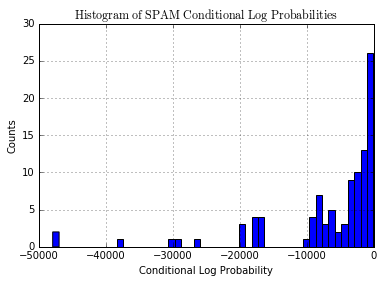

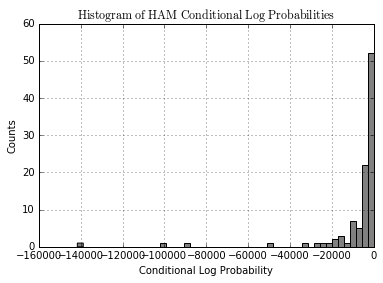

In [93]:
%matplotlib inline
"""
Reducer code for W261 exercise 2.3
"""
__author__="Carlos Eduardo Rodriguez Castillo"
__email__="cerodriguez@berkeley.edu"

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import sys

SPAM_log_probs = []
HAM_log_probs = []

f = open('hw2_311_output','r')
for line in f:
    line = line.strip()
    line_components = line.split("\t")
    if line_components[0] == "HAM_log_prob_cond_doc":
        SPAM_log_probs.extend([float(line_components[3])])
        HAM_log_probs.extend([float(line_components[1])])
        
plt.figure(1)
SPAM_log_probs_n, SPAM_log_probs_bins, SPAM_log_probs_patches = plt.hist(SPAM_log_probs, 50, facecolor='blue')
plt.xlabel('Conditional Log Probability')
plt.ylabel('Counts')
plt.title(r'$\mathrm{Histogram\ of\ SPAM\ Conditional\ Log\ Probabilities}$')
plt.grid(True)
plt.figure(2)
HAM_log_probs_n, HAM_log_probs_bins, HAM_log_probs_patches = plt.hist(HAM_log_probs, 50, facecolor='gray')
plt.xlabel('Conditional Log Probability')
plt.ylabel('Counts')
plt.title(r'$\mathrm{Histogram\ of\ HAM\ Conditional\ Log\ Probabilities}$')
plt.grid(True)
plt.show()

#### HW2.4 Multinomial Naive Bayes with Laplace +1 Smoothing

_Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences._

__ANSWER:__ 

We find that the misclassification rate using Laplace +1 smoothing is identical to that which we computed for the model without smoothing in part 2.3 (__0% misclassification error rate__). I believe that the reason that the answers are similar is that, while in 2.3 we do not have smoothing, the way we treat no appearances is not practically different from applying Laplace +1 smoothing.

The reason for this is that, in 2.3 when words do not appear in a class I add a very low log probability (i.e. -100) to the word, practically ensuring that the class will not be selected. In 2.4 this is analoguosly achieved because Laplace plus one smoothing, while ensuring that all words in the vocabulary have a probability, will assign a very small conditional log probability to word for the class (i.e. 1/(Total words in class + total words in class' vocabulary)), which translates practically ensuring that the class will not be selected as well.

Finally, it is important to note that, while the classfication performance did not change, the histograms show that the density of conditional log probabilities did indeed change for both classes. We see that the distribution seems to have a higher variance with Laplace smoothing as less of the distributions' volume is concentrated in the single highest bin of the histograms.

_Note: I only modified the code for the first MapReduce job (the job that fits and outputs the model) to output the model with smoothing; the second MapReduce job is the one developed in 2.3._

In [43]:
%%writefile mapperhw2_4.py
#!/usr/bin/python
"""
Mapper code for W261 exercise 2.4
"""
__author__="Carlos Eduardo Rodriguez Castillo"
__email__="cerodriguez@berkeley.edu"

## Import relevant libraries
import sys
import re
import json

## define mapper initialize function
def mapper_initialize():
    ## Create record dictionary and initialize values
    record_dictionary = {}
    record_dictionary["SPAM_total_counter"] = 0
    record_dictionary["HAM_total_counter"] = 0
    record_dictionary["words"] = {}
    return record_dictionary
    
## define map function
def map_function(record):
    ## Clean up and decompose record
    record = record.strip()
    record_parameters = record.split("\t")
    record_id = record_parameters[0]
    ## Here we do not error handle as we assume that classes
    ## have all been correctly coded
    record_class = int(record_parameters[1])
    record_document = ' '.join([str(x) for x in record_parameters[2:]])
    ## Parse record for spaces, commas (followed by spaces),
    ## periods (followed by spaces) and commas
    words = filter(None,
                  re.split("\s+|[.]\s+|[,]\s+|[,]",
                          record_document))
    ## Iterating through all the words in the record's document
    for word in words:
        ## NOTE: operating under the assumption that record_dictionary
        ##       is a global variable
        ## accessed if the current word is NOT in the record dictionary
        if word not in record_dictionary["words"].keys():
            ## initialize counters in dictionary for newly encountered word
            record_dictionary["words"][word] = {"SPAM_counter": 0,
                                      "HAM_counter": 0}
            ## increment counter under the appropriate class
            if record_class == 1:
                record_dictionary["words"][word]["SPAM_counter"] = record_dictionary["words"][word]["SPAM_counter"] + 1
                record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] + 1
            else:
                record_dictionary["words"][word]["HAM_counter"] = record_dictionary["words"][word]["HAM_counter"] + 1
                record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] + 1
        ## accessed if the current word is IN the record dictionary
        else:
            ## increment counter under the respective class
            if record_class == 1:
                record_dictionary["words"][word]["SPAM_counter"] = record_dictionary["words"][word]["SPAM_counter"] + 1
                record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] + 1
            else:
                record_dictionary["words"][word]["HAM_counter"] = record_dictionary["words"][word]["HAM_counter"] + 1
                record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] + 1
    ## emit the record dictionary
    ## print record_dictionary
if __name__ == "__main__":
    #record_dictionary = mapper_initialize()
    for line in sys.stdin:
        record_dictionary = mapper_initialize()
        map_function(line)
        ## emit the key value pair
        print "model\t%s" % json.dumps(record_dictionary)

Writing mapperhw2_4.py


In [44]:
!chmod a+x mapperhw2_4.py

In [61]:
%%writefile reducerhw2_4.py
#!/usr/bin/python
"""
Reducer code for W261 exercise 2.4
"""
__author__ = "Carlos Eduardo Rodriguez Castillo"
__email__ = "cerodriguez@berkeley.edu"

## Import relevant libraries
import sys
import re
import math
import json
import ast

## define reducer initialize function
def reducer_initialize():
    ## Create record dictionary and initialize values
    record_dictionary = {}
    record_dictionary["SPAM_total_counter"] = 0
    record_dictionary["HAM_total_counter"] = 0
    record_dictionary["SPAM_unconditional_prob"] = 0
    record_dictionary["HAM_unconditional_prob"] = 0
    record_dictionary["words"] = {}
    return record_dictionary
    
## define reduce function
def reduce_function(intermediateResult):
    ## turn line into JSON object
    intermediateResult = intermediateResult.split('\t')
    key = intermediateResult[0]
    value = intermediateResult[1]
    ## counts JSON object
    tempModel = json.dumps(value)
    tempModel = json.loads(tempModel)
    intermediateModel = ast.literal_eval(tempModel)
    ## increment total SPAM and HAM counts respectively
    record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] + intermediateModel["SPAM_total_counter"]
    record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] + intermediateModel["HAM_total_counter"]
    for word in intermediateModel["words"].keys():
        ## check to see if the word exists in cumulative dictionary
        if word in record_dictionary["words"].keys():
            ## word has already been added to the output dictionary
            record_dictionary["words"][word]["SPAM_counter"] = record_dictionary["words"][word]["SPAM_counter"] + intermediateModel["words"][word]["SPAM_counter"]
            record_dictionary["words"][word]["HAM_counter"] = record_dictionary["words"][word]["HAM_counter"] + intermediateModel["words"][word]["HAM_counter"]
        else:
            ## word has not been added to the output dictionary
            record_dictionary["words"][word] = {"SPAM_counter": 0,
                                      "HAM_counter": 0}
            record_dictionary["words"][word]["SPAM_counter"] = intermediateModel["words"][word]["SPAM_counter"]
            record_dictionary["words"][word]["HAM_counter"] = intermediateModel["words"][word]["HAM_counter"]

if __name__ == "__main__":
    record_dictionary = reducer_initialize()
    for line in sys.stdin:
        reduce_function(line)
    ######################################
    ######## +1 Laplace smoothing ########
    ######################################
    ## in order to implement +1 Laplace smoothing
    ## we iterate through the vocabulary and add one
    ## to each of the counters for the word in the classes
    ## as well as to the underlying total in the classes
    for word in record_dictionary["words"].keys():
        record_dictionary["words"][word]["HAM_counter"] = record_dictionary["words"][word]["HAM_counter"] + 1
        record_dictionary["words"][word]["SPAM_counter"] = record_dictionary["words"][word]["SPAM_counter"] + 1
        record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] + 1
        record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] + 1
    ## compute the unconditional probabilities for the classes
    record_dictionary["SPAM_unconditional_prob"] = float(record_dictionary["SPAM_total_counter"]) / (float(record_dictionary["SPAM_total_counter"]) + float(record_dictionary["HAM_total_counter"]))
    record_dictionary["HAM_unconditional_prob"] = float(record_dictionary["HAM_total_counter"]) / (float(record_dictionary["SPAM_total_counter"]) + float(record_dictionary["HAM_total_counter"]))
    ## iterate through vocabulary words to compute conditional probabilities
    for word in record_dictionary["words"].keys():
        sys.stderr.write("reporter:counter:Words,Vocabulary,1\n")
        record_dictionary["words"][word]["SPAM_conditional_prob"] = float(record_dictionary["words"][word]["SPAM_counter"]) / float(record_dictionary["SPAM_total_counter"])
        record_dictionary["words"][word]["HAM_conditional_prob"] = float(record_dictionary["words"][word]["HAM_counter"]) / float(record_dictionary["HAM_total_counter"])
    print record_dictionary

Overwriting reducerhw2_4.py


In [46]:
!chmod a+x reducerhw2_4.py

In [ ]:
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-mapper /home/cloudera/w261/HW2/mapperhw2_4.py \
-reducer /home/cloudera/w261/HW2/reducerhw2_4.py \
-input /user/cloudera/w261/hw2/2_3/* \
-output /user/cloudera/w261/hw2/hw2-output-2_4

In [ ]:
!hdfs dfs -cat /user/cloudera/w261/hw2/hw2-output-2_4/part-00000 > output_2_4_0

In [ ]:
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-files output_2_4_0#model \
-mapper /home/cloudera/w261/HW2/mapperhw2_31.py \
-reducer /home/cloudera/w261/HW2/reducerhw2_31.py \
-input /user/cloudera/w261/hw2/2_3/* \
-output /user/cloudera/w261/hw2/hw2-output-2_4_1

In [ ]:
!hdfs dfs -cat /user/cloudera/w261/hw2/hw2-output-2_4_1/* | \
grep Misclassifcation_error_rate_multinomial_Naive_Bayes_Classifier

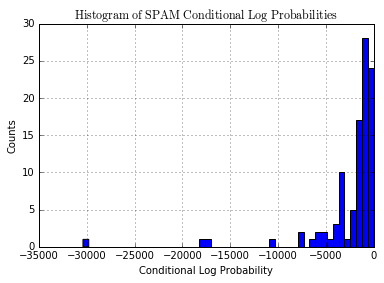

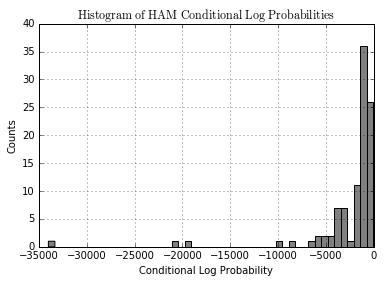

In [94]:
%matplotlib inline
"""
Reducer code for W261 exercise 2.3
"""
__author__="Carlos Eduardo Rodriguez Castillo"
__email__="cerodriguez@berkeley.edu"

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import sys

SPAM_log_probs = []
HAM_log_probs = []

f = open('hw2-output-2_4_1','r')
for line in f:
    line = line.strip()
    line_components = line.split("\t")
    if line_components[0] == "HAM_log_prob_cond_doc":
        SPAM_log_probs.extend([float(line_components[3])])
        HAM_log_probs.extend([float(line_components[1])])
        
plt.figure(1)
SPAM_log_probs_n, SPAM_log_probs_bins, SPAM_log_probs_patches = plt.hist(SPAM_log_probs, 50, facecolor='blue')
plt.xlabel('Conditional Log Probability')
plt.ylabel('Counts')
plt.title(r'$\mathrm{Histogram\ of\ SPAM\ Conditional\ Log\ Probabilities}$')
plt.grid(True)
plt.figure(2)
HAM_log_probs_n, HAM_log_probs_bins, HAM_log_probs_patches = plt.hist(HAM_log_probs, 50, facecolor='gray')
plt.xlabel('Conditional Log Probability')
plt.ylabel('Counts')
plt.title(r'$\mathrm{Histogram\ of\ HAM\ Conditional\ Log\ Probabilities}$')
plt.grid(True)
plt.show()

#### HW2.5

_Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset. Report the error and the change in error. HINT: ignore tokens with a frequency of less than three (3). Think of this as a preprocessing step. How many mapreduce jobs do you need to solve this homework?_

__ANSWER:__

__The misclassification error rate of the learnt multinomial naive bayes classifier is 6%__; this is a significant degradation from the 0% misclassification error rate that we recorded in parts 2.3 and 2.4.

This homework exercise can be resolved with two MapReduce jobs like the classification exercises encountered earlier in the homework assignment. The work of removing words with frequencies less than three (and adjusting total counts of words in the respective classes appropriately) is done in the reduce phase of the model fitting MapReduce job (once the model has been computed I run through it again and adjust it for frequency floor).

As far as the histograms are concerned, they follow similar trends to those in 2.4; the histograms show that the density of conditional log probabilities did indeed change for both classes from what we observed in 2.3 (but not so much from what is observed in 2.4). We see that the distribution seems to have a higher variance with Laplace smoothing and a frequency floor of 3 as less of the distributions' volume is concentrated in the single highest bin of the histograms.

_Note: I only modified the code for the first MapReduce job (the job that fits and outputs the model) to output the model with a vocabulary that ignores words with a frequency that is smaller than three in the corpus; the second MapReduce job is the one developed in 2.3._

In [70]:
%%writefile mapperhw2_5.py
#!/usr/bin/python
"""
Mapper code for W261 exercise 2.5
"""
__author__="Carlos Eduardo Rodriguez Castillo"
__email__="cerodriguez@berkeley.edu"

## Import relevant libraries
import sys
import re
import json

## define mapper initialize function
def mapper_initialize():
    ## Create record dictionary and initialize values
    record_dictionary = {}
    record_dictionary["SPAM_total_counter"] = 0
    record_dictionary["HAM_total_counter"] = 0
    record_dictionary["words"] = {}
    return record_dictionary
    
## define map function
def map_function(record):
    ## Clean up and decompose record
    record = record.strip()
    record_parameters = record.split("\t")
    record_id = record_parameters[0]
    ## Here we do not error handle as we assume that classes
    ## have all been correctly coded
    record_class = int(record_parameters[1])
    record_document = ' '.join([str(x) for x in record_parameters[2:]])
    ## Parse record for spaces, commas (followed by spaces),
    ## periods (followed by spaces) and commas
    words = filter(None,
                  re.split("\s+|[.]\s+|[,]\s+|[,]",
                          record_document))
    ## Iterating through all the words in the record's document
    for word in words:
        ## NOTE: operating under the assumption that record_dictionary
        ##       is a global variable
        ## accessed if the current word is NOT in the record dictionary
        if word not in record_dictionary["words"].keys():
            ## initialize counters in dictionary for newly encountered word
            record_dictionary["words"][word] = {"SPAM_counter": 0,
                                      "HAM_counter": 0}
            ## increment counter under the appropriate class
            if record_class == 1:
                record_dictionary["words"][word]["SPAM_counter"] = record_dictionary["words"][word]["SPAM_counter"] + 1
                record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] + 1
            else:
                record_dictionary["words"][word]["HAM_counter"] = record_dictionary["words"][word]["HAM_counter"] + 1
                record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] + 1
        ## accessed if the current word is IN the record dictionary
        else:
            ## increment counter under the respective class
            if record_class == 1:
                record_dictionary["words"][word]["SPAM_counter"] = record_dictionary["words"][word]["SPAM_counter"] + 1
                record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] + 1
            else:
                record_dictionary["words"][word]["HAM_counter"] = record_dictionary["words"][word]["HAM_counter"] + 1
                record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] + 1
    ## emit the record dictionary
    ## print record_dictionary
if __name__ == "__main__":
    #record_dictionary = mapper_initialize()
    for line in sys.stdin:
        record_dictionary = mapper_initialize()
        map_function(line)
        ## emit the key value pair
        print "model\t%s" % json.dumps(record_dictionary)

Writing mapperhw2_5.py


In [71]:
!chmod a+x mapperhw2_5.py

In [74]:
%%writefile reducerhw2_5.py
#!/usr/bin/python
"""
Reducer code for W261 exercise 2.5
"""
__author__ = "Carlos Eduardo Rodriguez Castillo"
__email__ = "cerodriguez@berkeley.edu"

## Import relevant libraries
import sys
import re
import math
import json
import ast

## define reducer initialize function
def reducer_initialize():
    ## Create record dictionary and initialize values
    record_dictionary = {}
    record_dictionary["SPAM_total_counter"] = 0
    record_dictionary["HAM_total_counter"] = 0
    record_dictionary["SPAM_unconditional_prob"] = 0
    record_dictionary["HAM_unconditional_prob"] = 0
    record_dictionary["words"] = {}
    return record_dictionary
    
## define reduce function
def reduce_function(intermediateResult):
    ## turn line into JSON object
    intermediateResult = intermediateResult.split('\t')
    key = intermediateResult[0]
    value = intermediateResult[1]
    ## counts JSON object
    tempModel = json.dumps(value)
    tempModel = json.loads(tempModel)
    intermediateModel = ast.literal_eval(tempModel)
    ## increment total SPAM and HAM counts respectively
    record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] + intermediateModel["SPAM_total_counter"]
    record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] + intermediateModel["HAM_total_counter"]
    for word in intermediateModel["words"].keys():
        ## check to see if the word exists in cumulative dictionary
        if word in record_dictionary["words"].keys():
            ## word has already been added to the output dictionary
            record_dictionary["words"][word]["SPAM_counter"] = record_dictionary["words"][word]["SPAM_counter"] + intermediateModel["words"][word]["SPAM_counter"]
            record_dictionary["words"][word]["HAM_counter"] = record_dictionary["words"][word]["HAM_counter"] + intermediateModel["words"][word]["HAM_counter"]
        else:
            ## word has not been added to the output dictionary
            record_dictionary["words"][word] = {"SPAM_counter": 0,
                                      "HAM_counter": 0}
            record_dictionary["words"][word]["SPAM_counter"] = intermediateModel["words"][word]["SPAM_counter"]
            record_dictionary["words"][word]["HAM_counter"] = intermediateModel["words"][word]["HAM_counter"]

if __name__ == "__main__":
    record_dictionary = reducer_initialize()
    for line in sys.stdin:
        reduce_function(line)
    ###########################################
    # Removing words with frequency 2 or less #
    ###########################################
    ## we go through every word in the vocabulary
    ## if it has a frequency of 2 or less
    ## the word is removed from the vocabulary
    ## and its frequency is subtracted from the total for the class
    for word in record_dictionary["words"].keys():
        total_frequency = record_dictionary["words"][word]["HAM_counter"] + record_dictionary["words"][word]["SPAM_counter"]
        if total_frequency <= 2:
            record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] - record_dictionary["words"][word]["HAM_counter"]
            record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] - record_dictionary["words"][word]["SPAM_counter"]
            record_dictionary["words"].pop(word, 0)   
    
    ######################################
    ######## +1 Laplace smoothing ########
    ######################################
    ## in order to implement +1 Laplace smoothing
    ## we iterate through the vocabulary and add one
    ## to each of the counters for the word in the classes
    ## as well as to the underlying total in the classes
    for word in record_dictionary["words"].keys():
        record_dictionary["words"][word]["HAM_counter"] = record_dictionary["words"][word]["HAM_counter"] + 1
        record_dictionary["words"][word]["SPAM_counter"] = record_dictionary["words"][word]["SPAM_counter"] + 1
        record_dictionary["SPAM_total_counter"] = record_dictionary["SPAM_total_counter"] + 1
        record_dictionary["HAM_total_counter"] = record_dictionary["HAM_total_counter"] + 1
    ## compute the unconditional probabilities for the classes
    record_dictionary["SPAM_unconditional_prob"] = float(record_dictionary["SPAM_total_counter"]) / (float(record_dictionary["SPAM_total_counter"]) + float(record_dictionary["HAM_total_counter"]))
    record_dictionary["HAM_unconditional_prob"] = float(record_dictionary["HAM_total_counter"]) / (float(record_dictionary["SPAM_total_counter"]) + float(record_dictionary["HAM_total_counter"]))
    ## iterate through vocabulary words to compute conditional probabilities
    for word in record_dictionary["words"].keys():
        sys.stderr.write("reporter:counter:Words,Vocabulary,1\n")
        record_dictionary["words"][word]["SPAM_conditional_prob"] = float(record_dictionary["words"][word]["SPAM_counter"]) / float(record_dictionary["SPAM_total_counter"])
        record_dictionary["words"][word]["HAM_conditional_prob"] = float(record_dictionary["words"][word]["HAM_counter"]) / float(record_dictionary["HAM_total_counter"])
    print record_dictionary

Writing reducerhw2_5.py


In [75]:
!chmod a+x reducerhw2_5.py

In [ ]:
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-mapper /home/cloudera/w261/HW2/mapperhw2_5.py \
-reducer /home/cloudera/w261/HW2/reducerhw2_5.py \
-input /user/cloudera/w261/hw2/2_3/* \
-output /user/cloudera/w261/hw2/hw2-output-2_5

In [ ]:
!hdfs dfs -cat /user/cloudera/w261/hw2/hw2-output-2_5/* > output_2_5_0

In [ ]:
!hdfs dfs -rm -r /user/cloudera/w261/hw2/hw2-output-2_5_1
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-files output_2_5_0#model \
-mapper /home/cloudera/w261/HW2/mapperhw2_31.py \
-reducer /home/cloudera/w261/HW2/reducerhw2_31.py \
-input /user/cloudera/w261/hw2/2_3/* \
-output /user/cloudera/w261/hw2/hw2-output-2_5_1

In [ ]:
hdfs dfs -cat /user/cloudera/w261/hw2/hw2-output-2_5_1/* | \
grep Misclassifcation_error_rate_multinomial_Naive_Bayes_Classifier

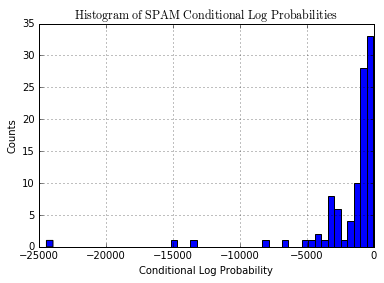

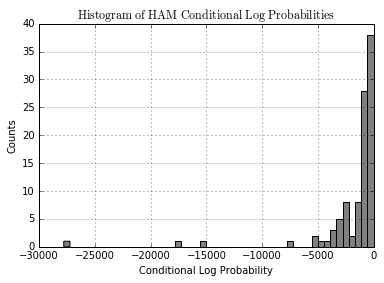

In [95]:
%matplotlib inline
"""
Histograms code for W261 exercise 2.5
"""
__author__="Carlos Eduardo Rodriguez Castillo"
__email__="cerodriguez@berkeley.edu"

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import sys

SPAM_log_probs = []
HAM_log_probs = []

f = open('hw2-output-2_5','r')
for line in f:
    line = line.strip()
    line_components = line.split("\t")
    if line_components[0] == "HAM_log_prob_cond_doc":
        SPAM_log_probs.extend([float(line_components[3])])
        HAM_log_probs.extend([float(line_components[1])])
        
plt.figure(1)
SPAM_log_probs_n, SPAM_log_probs_bins, SPAM_log_probs_patches = plt.hist(SPAM_log_probs, 50, facecolor='blue')
plt.xlabel('Conditional Log Probability')
plt.ylabel('Counts')
plt.title(r'$\mathrm{Histogram\ of\ SPAM\ Conditional\ Log\ Probabilities}$')
plt.grid(True)
plt.figure(2)
HAM_log_probs_n, HAM_log_probs_bins, HAM_log_probs_patches = plt.hist(HAM_log_probs, 50, facecolor='gray')
plt.xlabel('Conditional Log Probability')
plt.ylabel('Counts')
plt.title(r'$\mathrm{Histogram\ of\ HAM\ Conditional\ Log\ Probabilities}$')
plt.grid(True)
plt.show()

#### HW2.6 Benchmark your code

Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm

It always a good idea to benchmark your solutions against publicly available libraries such as SciKit-Learn, The Machine Learning toolkit available in Python. In this exercise, we benchmark ourselves against the SciKit-Learn implementation of multinomial Naive Bayes.  For more information on this implementation see: http://scikit-learn.org/stable/modules/naive_bayes.html

In this exercise, please complete the following:

- Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
- Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error
- Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn

__ANSWER:__

Running the multinomial naive bayes algorithm with default settings from SciKit-Learn over the training data we obtain a misclassification rate of 0%.

While on paper these results are indicative of our freqency floor algorithm being inferior to the SciKit-Learn standard implementations, I have trouble interpretting the results seriously as we are training and testing on the same dataset, which inherently results in overly optimistic results as we learned in weeks 1 and 2. Moreover, we have the same performnce as SciKit-Learn in the vanilla and Laplace +1 smoothing cases.

I believe that the difference in the training error rates between my MapReduce multinomial naive bayes implementation and the multinomial naive bayes implementation in SciKit-Learn is that, once we introduce pre-processing in the form of a floor frequency of three, we are fundamentally departing from the default settings of training the model. Particularly, I believe that removing relatively rare words can have a significant effect in accuracy because of my assumption that these words could very well be in a single class due to their low frequency (less chances to be in both classes).

See below for a table comparing resutls:

|Model|Misclassification error rate|
|---|---|
|SciKit-Learn multinomial naive bayes (default settings)|0%|
|MapReduce multinomial naive bayes|0%|
|MapReduce multinomial naive bayes (Laplace +1 smoothing)|0%|
|MapReduce multinomial naive bayes (Laplace +1 smoothing and frequency floor = 3)|6%|

In [85]:
import numpy as np

from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import sys
import re
import logging
import pprint
from math import log

## setting up logger
logging_directory_path = '/home/crodriguez1/W261/HW1/log'
logging_file = logging_directory_path + "/" + 'sklearn_log.log'
log_format = '%(levelname)s\n%(asctime)s.%(msecs)-3d filename:%(filename)-20s line:%(lineno)-5d \n%(message)s\n\n'
log_date_format = '%H:%M:%S'
logging.basicConfig(filename = logging_file,
    stream = sys.stderr,
    level = logging.DEBUG,
    format = log_format,
    datefmt = log_date_format)
suds_logger = logging.getLogger("suds")
suds_logger.propagate = False

WORD_RE = re.compile(r"[\w']+")

train_data = []
train_labels = []

## Training error calculating function
def training_error(labels, prediction):
    errors = 0
    num_observations = len(labels)
    for truth, prediction in zip(train_labels ,MultiNB_predicted):
        logging.debug("Truth: %s | Prediction: %s"% (truth, prediction))
        if truth != prediction:
            errors = errors + 1
    print "The training error is %.2f" % (float(errors)/float(num_observations))

with open ("/home/crodriguez1/W261/HW1/enronemail_1h.txt", "r") as myfile:
    for line in myfile:
        line_components = line.split("\t")
        output_variable = int(line_components[1])
        line = ' '.join([str(x) for x in line_components[2:]])
        train_data.extend([line])
        train_labels.extend([output_variable])
# Initialize CountVectorizer and fit and transform the data
cv = CountVectorizer()
cv_train = cv.fit_transform(train_data)

## Create and fit MultinomialNB classifier (default settings)
MultiNB = MultinomialNB()
MultiNB.fit(cv_train,train_labels)
MultiNB_predicted = MultiNB.predict(cv_train)

## Create and fit MultinomialNB classifier (default settings)
BernoulliNB = BernoulliNB()
BernoulliNB.fit(cv_train,train_labels)
BernoulliNB_predicted = BernoulliNB.predict(cv_train)

print "ANSWER:"
print "HW1.6 A. Multinomial Naive Bayes algorithm (using default settings)"
training_error(train_labels, MultiNB_predicted)
print "HW1.6 B. Bernoulli Naive Bayes algorithm (using default settings)"
training_error(train_labels, BernoulliNB_predicted)
print "HW1.6 C. From the results in HW1.5 we see that the training error for the Multinomial NB is 3%"

ANSWER:
HW1.6 A. Multinomial Naive Bayes algorithm (using default settings)
The training error is 0.00
HW1.6 B. Bernoulli Naive Bayes algorithm (using default settings)
The training error is 0.00
HW1.6 C. From the results in HW1.5 we see that the training error for the Multinomial NB is 3%
